In [1]:
import os
from pathlib import Path
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import math
from PIL import Image
from skimage.io import imread, imshow
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt
import warnings
# Ignore font-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'  # Specify a fallback font
plt.rcParams['font.family'] = 'sans-serif'  # Fallback to sans-serif if the desired font is not found

2023-08-11 06:14:29.376542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 06:14:29.465320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 06:14:29.466592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 06:14:31.102096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:

def metadat_func(images_dir):
    """doc
    """
    list_dataframes = {}
    for _, labels_dir, _ in os.walk(images_dir, topdown=True):
        for breed_class in labels_dir:
            class_dir = os.path.join(images_dir, breed_class)
            class_files = list_files_in_directory(class_dir)
            list_dataframes.update({breed_class: class_files})
    return list_dataframes


def list_files_in_directory(directory_path):
    """_summary_

    Parameters
    ----------
    directory_path : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    try:
        # Get a list of files and directories in the specified path
        files_and_directories = os.listdir(directory_path)

        # Filter out only the files from the list
        files_list = [
            image_dir_path
            for file in files_and_directories
            if os.path.isfile(image_dir_path:= os.path.join(directory_path, file))
        ]
        return files_list
    except Exception:
        pass
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

def plot_image_bounding_box(images, boxes, classnames, classes, scores = False):
    """doc
    """
    images_no = len(images)
    SqrtN = int(math.ceil(math.sqrt(images_no)))
    mean_aspect_ratio = sum([image[1]/image[0] for image in images]) / len(images)
    fig = plt.figure(figsize=(15, 15 / mean_aspect_ratio), frameon=False)

    for k in range(images_no):
        ax= plt.subplots(SqrtN, SqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
                x, y, w, h = (
                    box[0],
                    box[1],
                    box[2] - box[0],
                    box[3] - box[1],
                )  # convert x1 y1 x2 y2 into xywh
                # x, y, w, h = (box[0], box[1], box[2], box[3])
                # label = classnames[klass-1] # predicted classes are 1-based
                label = classnames[klass]
                if scores:
                    label += " " + str(int(scores[k][i] * 100)) + "%"
                rect = mpl.patches.Rectangle(
                    (x, y), w, h, linewidth=4, edgecolor="#00000080", facecolor="none"
                )
                ax.add_patch(rect)
                rect = mpl.patches.Rectangle(
                    (x, y), w, h, linewidth=2, edgecolor="#FFFF00FF", facecolor="none"
                )
                ax.add_patch(rect)
                plt.text(
                    x,
                    y,
                    label,
                    size=16,
                    ha="left",
                    va="top",
                    color="#FFFF00FF",
                    bbox=dict(
                        boxstyle="round", ec="#00000080", fc="#0000004E", linewidth=3
                    ),
                )
                plt.text(
                    x,
                    y,
                    label,
                    size=16,
                    ha="left",
                    va="top",
                    color="#FFFF00FF",
                    bbox=dict(
                        boxstyle="round", ec="#FFFF00FF", fc="#0000004E", linewidth=1.5
                    ),
                )
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.02, hspace=0.02)
        plt.show()


In [3]:
os.chdir("../")
%pwd

'/workspace/dogbreeds_dect'

In [4]:
dataframe = pd.read_csv('data/raw/metadat.csv')
dataframe.head()

,Unnamed: 0,folder,filename,database,width,height,depth,object_name,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,0,02085620,n02085620_10074,ImageNet database,333,500,3,Chihuahua,Unspecified,0,0,25,10,276,498
1,0,02085620,n02085620_10131,ImageNet database,395,495,3,Chihuahua,Unspecified,0,0,49,9,393,493
2,0,02085620,n02085620_10621,ImageNet database,500,298,3,Chihuahua,Unspecified,0,0,142,43,335,250
3,0,02085620,n02085620_1073,ImageNet database,345,500,3,Chihuahua,Unspecified,0,0,0,27,312,498
4,0,02085620,n02085620_10976,ImageNet database,322,484,3,Chihuahua,Unspecified,0,0,90,104,242,452


In [5]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   20580 non-null  int64 
 1   folder       20580 non-null  object
 2   filename     20580 non-null  object
 3   database     20580 non-null  object
 4   width        20580 non-null  int64 
 5   height       20580 non-null  int64 
 6   depth        20580 non-null  int64 
 7   object_name  20580 non-null  object
 8   pose         19956 non-null  object
 9   truncated    20580 non-null  int64 
 10  difficult    20580 non-null  int64 
 11  xmin         20580 non-null  int64 
 12  ymin         20580 non-null  int64 
 13  xmax         20580 non-null  int64 
 14  ymax         20580 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 2.4+ MB


In [6]:
dataframe.shape

(20580, 15)

In [7]:
dataframe['height'].min(), dataframe['height'].max(), round(dataframe['height'].mean(),),  round(dataframe['width'].mean(),)

(100, 2562, 386, 443)

In [8]:
dataframe[dataframe['depth'] != 3].value_counts()

Series([], Name: count, dtype: int64)

In [9]:
dogbreed = dataframe['object_name'].unique()
print(len(dogbreed))

120


In [10]:
for num in range(0,40,10):
    print(dogbreed[num :num+10])

['Chihuahua' 'Japanese_spaniel' 'Maltese_dog' 'Pekinese' 'Shih-Tzu'
 'Blenheim_spaniel' 'papillon' 'toy_terrier' 'Rhodesian_ridgeback'
 'Afghan_hound']
['basset' 'beagle' 'bloodhound' 'bluetick' 'black-and-tan_coonhound'
 'Walker_hound' 'English_foxhound' 'redbone' 'borzoi' 'Irish_wolfhound']
['Italian_greyhound' 'whippet' 'Ibizan_hound' 'Norwegian_elkhound'
 'otterhound' 'Saluki' 'Scottish_deerhound' 'Weimaraner'
 'Staffordshire_bullterrier' 'American_Staffordshire_terrier']
['Bedlington_terrier' 'Border_terrier' 'Kerry_blue_terrier'
 'Irish_terrier' 'Norfolk_terrier' 'Norwich_terrier' 'Yorkshire_terrier'
 'wire-haired_fox_terrier' 'Lakeland_terrier' 'Sealyham_terrier']


In [11]:
dataframe['pose'].unique()

array(['Unspecified', nan], dtype=object)

In [12]:
dataframe['difficult'].unique()

array([0])

In [13]:
dataframe['truncated'].unique()

array([0])

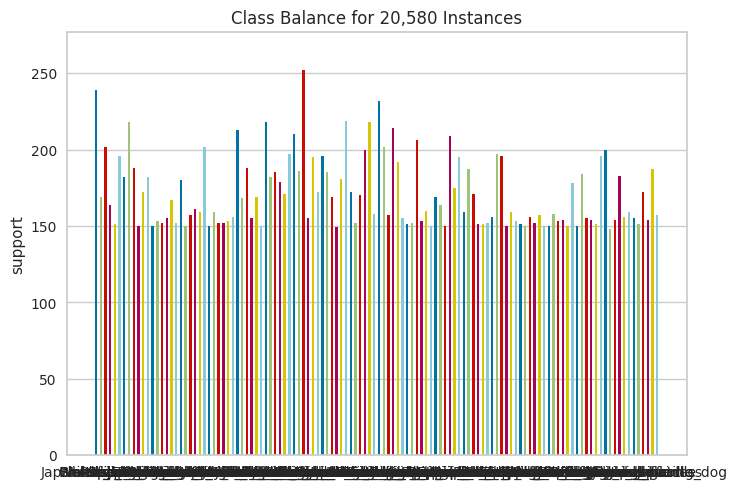

<Axes: title={'center': 'Class Balance for 20,580 Instances'}, ylabel='support'>

In [15]:

viz = ClassBalance(labels=dogbreed).fit(dataframe['object_name'])
viz.finalize(title = 'Test')
viz.show()

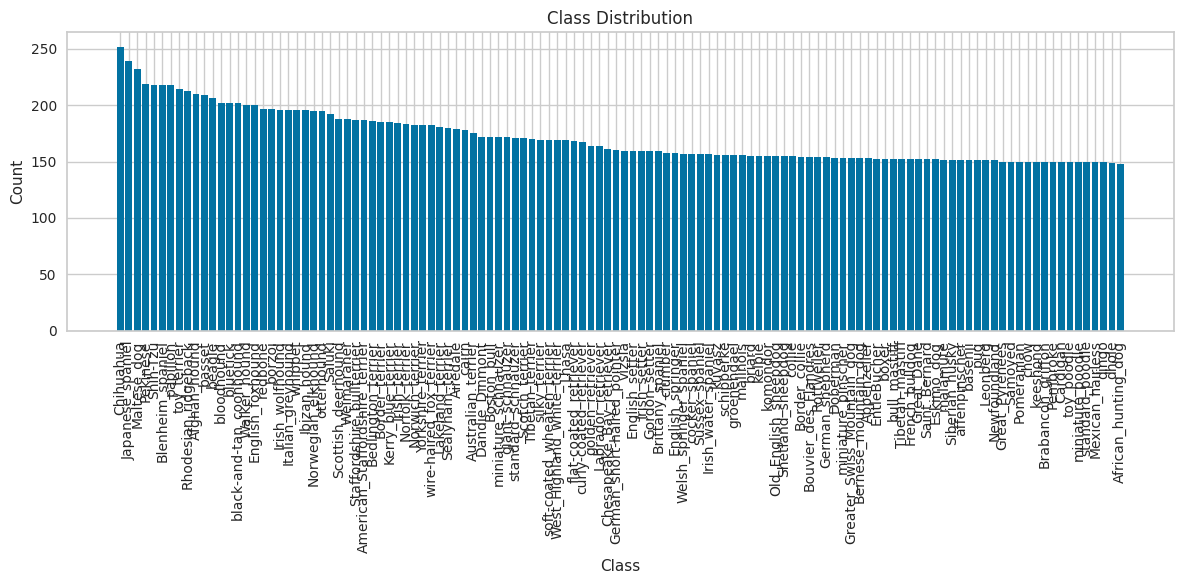

In [32]:
class_counts = dataframe['object_name'].value_counts()
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(dogbreed, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels don't overlap
plt.show()


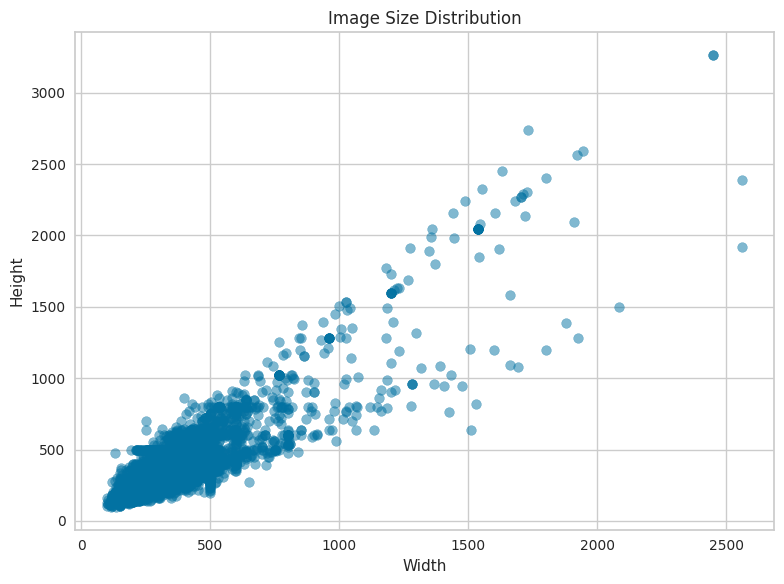

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(dataframe['height'], dataframe['width'], alpha=0.5)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

TypeError: '<=' not supported between instances of 'pandas._libs.interval.Interval' and 'float'

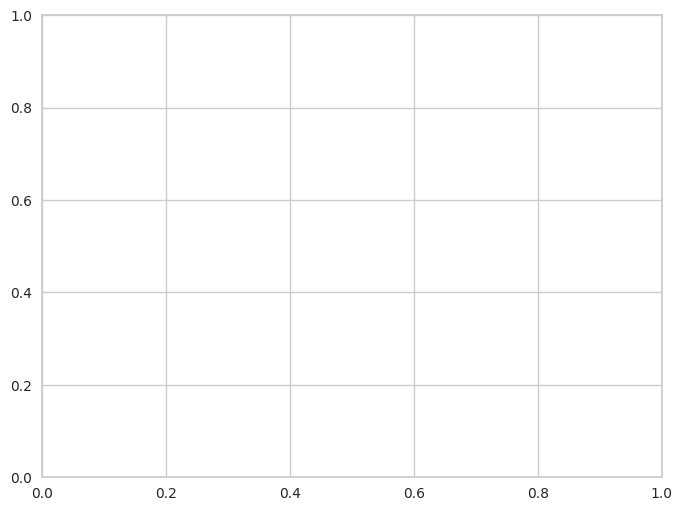

In [37]:
bin_edges = [0, 200, 400, 600, 800]
dataframe['Width Bins'] = pd.cut(dataframe['width'], bins=bin_edges)

# Create a histogram of binned data
plt.figure(figsize=(8, 6))
plt.hist(dataframe['Width Bins'], bins=bin_edges, edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
images_dir = 'data/raw/stanford-dogs-dataset/images/Images/'
data = metadat_func(images_dir)

In [15]:
img = imread(data['n02085620-Chihuahua'][10])
img.shape

(375, 500, 3)

(-0.5, 499.5, 374.5, -0.5)

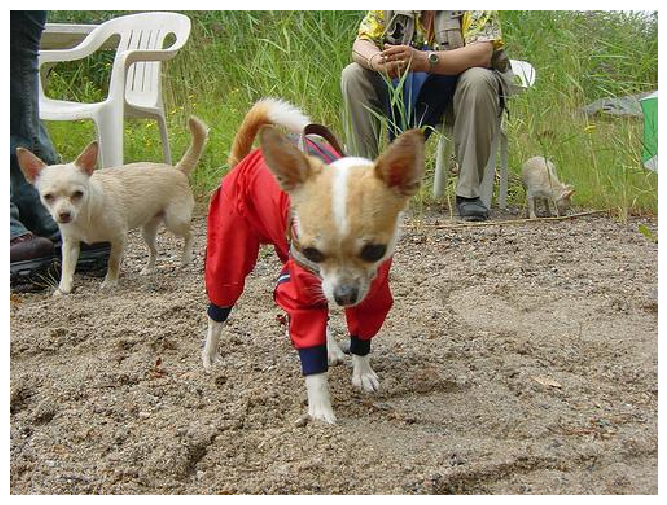

In [16]:
imshow(img)
plt.axis('off')

In [17]:
sample_boxes = dataframe.loc[10, 'xmin':'ymax'].values
sample_boxes

array([3, 81, 156, 225], dtype=object)

In [28]:
plot_image_bounding_box(images = img, boxes = sample_boxes, classnames = ['ladi'], classes = ['james'])

/tmp/ipykernel_9172/3938191574.py:53: RuntimeWarning: divide by zero encountered in divide
  mean_aspect_ratio = sum([image[1]/image[0] for image in images]) / len(images)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.